In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [57]:
df = pd.read_csv('D:/Projects/ML/Personalized Recommendation System/dataset/ratings_Electronics (1).csv')

In [58]:
df.columns= ['userId','productId', 'Rating', 'timestamp']
df

,userId,productId,Rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600
...,...,...,...,...
7824476,A2YZI3C9MOHC0L,BT008UKTMW,5.0,1396569600
7824477,A322MDK0M89RHN,BT008UKTMW,5.0,1313366400
7824478,A1MH90R0ADMIK0,BT008UKTMW,4.0,1404172800
7824479,A10M2KEFPEQDHN,BT008UKTMW,4.0,1297555200


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   Rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [60]:

df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

df['Year'] = df['timestamp'].dt.year
df['Month'] = df['timestamp'].dt.month

df['Rating'] = df['Rating'].astype(int)
df['userId'] = df['userId'].astype('str')
df['productId'] = df['productId'].astype('str')

In [61]:
df

,userId,productId,Rating,timestamp,Year,Month
0,A2CX7LUOHB2NDG,0321732944,5,2012-07-01,2012,7
1,A2NWSAGRHCP8N5,0439886341,1,2013-04-29,2013,4
2,A2WNBOD3WNDNKT,0439886341,3,2013-07-22,2013,7
3,A1GI0U4ZRJA8WN,0439886341,1,2012-04-18,2012,4
4,A1QGNMC6O1VW39,0511189877,5,2014-04-14,2014,4
...,...,...,...,...,...,...
7824476,A2YZI3C9MOHC0L,BT008UKTMW,5,2014-04-04,2014,4
7824477,A322MDK0M89RHN,BT008UKTMW,5,2011-08-15,2011,8
7824478,A1MH90R0ADMIK0,BT008UKTMW,4,2014-07-01,2014,7
7824479,A10M2KEFPEQDHN,BT008UKTMW,4,2011-02-13,2011,2


In [62]:
df.isna().sum()

userId       0
productId    0
Rating       0
timestamp    0
Year         0
Month        0
dtype: int64

In [63]:
df.duplicated().sum()

0

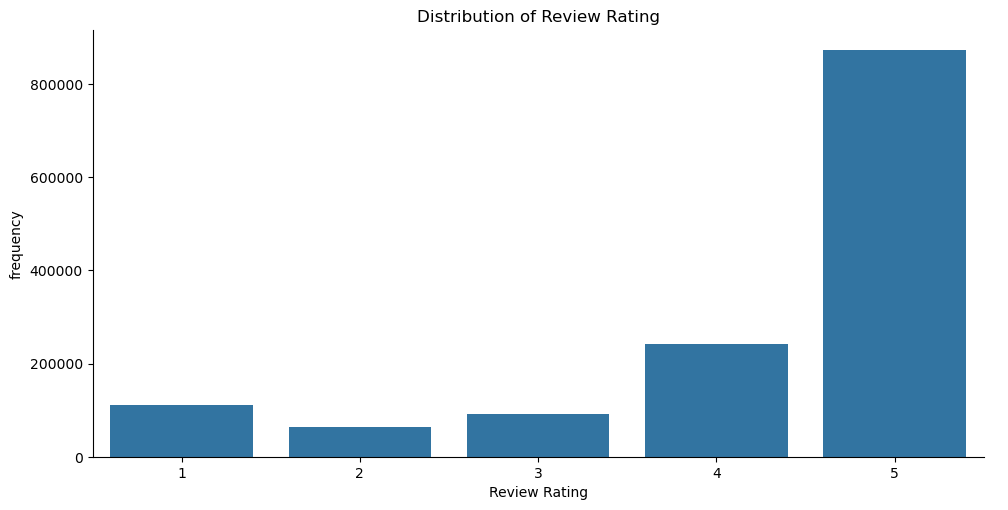

In [75]:
sns.catplot(x=df['Rating'], aspect=2, data=df, kind='count')
plt.title('Distribution of Review Rating')
plt.xlabel('Review Rating')
plt.ylabel('frequency')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

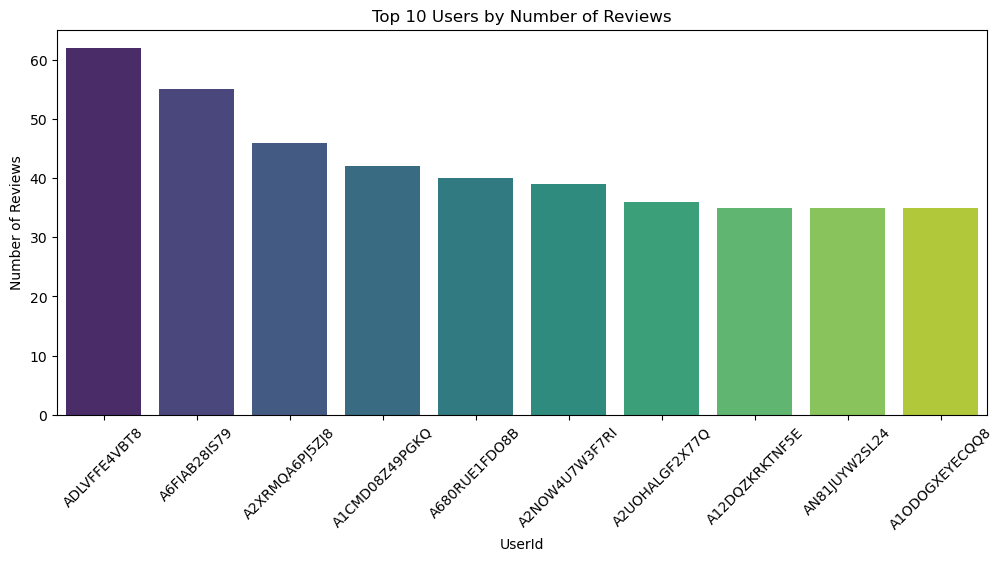

In [86]:
top_users = df['userId'].value_counts().head(10)
plt.figure(figsize=(12, 5))
sns.barplot(x=top_users.index, y=top_users.values, hue=top_users.index, palette='viridis', dodge=False)
plt.title('Top 10 Users by Number of Reviews')
plt.xlabel('UserId')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.show()

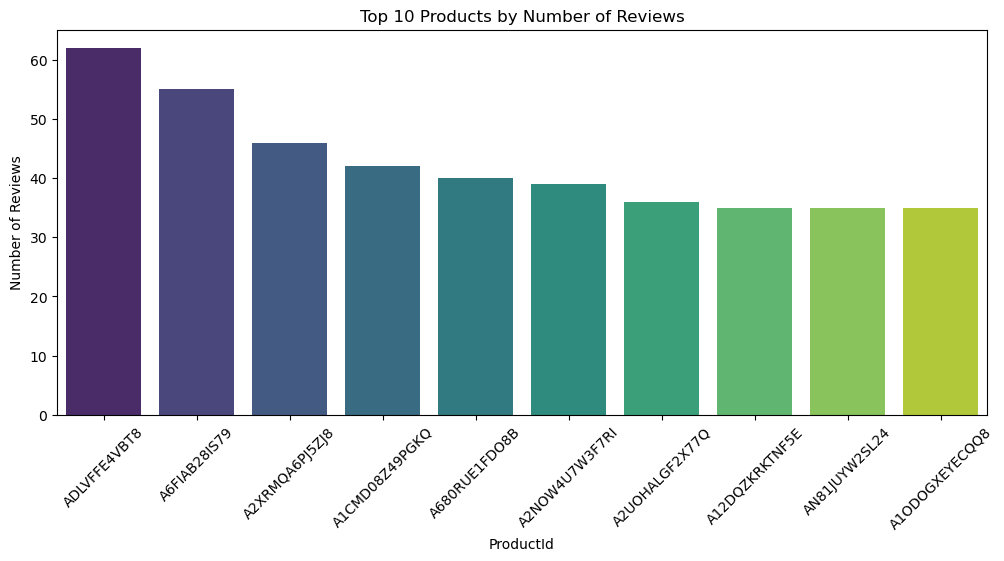

In [85]:
top_products = df['productId'].value_counts().head(10)
top_products

plt.figure(figsize=(12, 5))
sns.barplot(x=top_users.index, y=top_users.values, hue=top_users.index, palette='viridis')
plt.title('Top 10 Products by Number of Reviews')
plt.xlabel('ProductId')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.show()

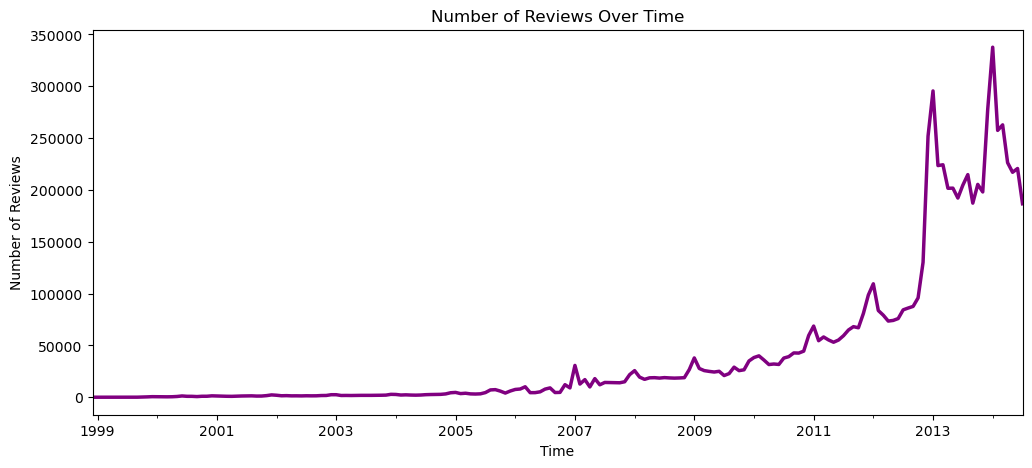

In [67]:
plt.figure(figsize=(12, 5))
df.groupby(df['timestamp'].dt.to_period('M')).size().plot(kind='line', linewidth =2.5, color='purple')
plt.title('Number of Reviews Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Reviews')
plt.show()

In [68]:
ratings_count = df.groupby('productId')['Rating'].count()

popular_products = ratings_count[ratings_count >= 1000].index

df = df[df['productId'].isin(popular_products)]

df = df.drop(columns=['timestamp'])

df.shape

(1379717, 5)

In [69]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

reader = Reader(rating_scale=(1,5))
data =Dataset.load_from_df(df[['userId','productId','Rating']],reader)

trainset, testset =train_test_split(data, test_size=0.2, random_state=0) 

In [70]:
model = SVD(n_epochs= 10, lr_all= 0.005, reg_all= 0.4)
model.fit(trainset)

In [71]:
predictions = model.test(testset)

accuracy.rmse(predictions)

RMSE: 1.1959


1.1958655504957905

In [72]:
# from surprise.model_selection import GridSearchCV
# para_grid = {
#     'n_epochs': [5, 10],
#     'lr_all': [0.002, 0.005],
#     'reg_all': [0.4, 0.6]
# }

# gs = GridSearchCV(SVD, para_grid, measures=['rmse'], cv=3)

# gs.fit(data)

# print('Best RMSE:', gs.best_score['rmse'])

# print('Best parameters:', gs.best_params['rmse'])

Best parameters: {'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


In [73]:
import random

random.seed(0)

random_test_samples = random.sample(testset, 10)

predictions = [model.predict(uid, iid, r_ui) for (uid, iid, r_ui) in random_test_samples]


for prediction in predictions:
    if prediction.est > 4:
        rec = True
    else:
        rec = False
    print(f"User: {prediction.uid}, Item: {prediction.iid}, Actual Rating: {prediction.r_ui}, Predicted Rating: {prediction.est:.2f}, recommended for you: {rec}")

User: A3H7FEKB32IKH7, Item: B0074BW614, Actual Rating: 5.0, Predicted Rating: 4.41, recommended for you: True
User: A2WD6FD379LOKX, Item: B003XM73P2, Actual Rating: 5.0, Predicted Rating: 4.52, recommended for you: True
User: A3ON7EYG49ICE3, Item: B000HPV3RW, Actual Rating: 5.0, Predicted Rating: 4.39, recommended for you: True
User: A36B3WJRCXH4SF, Item: B0098F5W0Q, Actual Rating: 5.0, Predicted Rating: 4.21, recommended for you: True
User: AJRBAXC2H0396, Item: B002HMWQE2, Actual Rating: 1.0, Predicted Rating: 3.56, recommended for you: False
User: A38XWFP5CQUIWU, Item: B007R5YDYA, Actual Rating: 5.0, Predicted Rating: 4.54, recommended for you: True
User: AVOCNUFOXUCA6, Item: B00119T6NQ, Actual Rating: 5.0, Predicted Rating: 4.16, recommended for you: True
User: A3PVOHJCEVJZT9, Item: B003DZ1684, Actual Rating: 3.0, Predicted Rating: 4.39, recommended for you: True
User: A1L449ANLVYIEC, Item: B004QK7HI8, Actual Rating: 5.0, Predicted Rating: 4.10, recommended for you: True
User: A3QLR

In [74]:
user_id = 'A25C2M3QF9G7OQ' 

items = df['productId'].unique()

rated_items = df[df['userId'] == user_id]['productId'].values
unrated_items = [item for item in items if item not in rated_items]

predictions = [model.predict(user_id, item) for item in unrated_items]

# Print the predicted ratings
for prediction in predictions[:10]:
    print(f"Item {prediction.iid} - Predicted Rating: {prediction.est}")

Item 0972683275 - Predicted Rating: 4.552958960331734
Item B00001P4ZH - Predicted Rating: 4.530288233907162
Item B00001WRSJ - Predicted Rating: 4.701724981963474
Item B00004SABB - Predicted Rating: 4.189500604041927
Item B00004SB92 - Predicted Rating: 4.200070609227162
Item B00004T8R2 - Predicted Rating: 4.441530482989186
Item B00004ZCJE - Predicted Rating: 4.279805235087491
Item B00005ATMB - Predicted Rating: 4.466571275749341
Item B00005LEN4 - Predicted Rating: 4.63795763929125
Item B00005N6KG - Predicted Rating: 4.2235143503262895
